# Open University Learning Analytics Dataset (OULAD) Data Cleaning and EDA

Possible research questions:
- why are there so many late submissions?
- demographics correlation to outcomes
- participation correlation to outcomes
- what predicts a student's sucess
- predicting with a subset of data - e.g. technical courses

Tableau metrics
__[source](https://www.docebo.com/learning-network/blog/lms-metrics/)__

Different data set
- what predicts LMS learner satisfaction
- instructor perfpormance
__[other ideas](https://www.linkedin.com/pulse/e-learning-kpis-measures-success-digital-learning-dr-aman-jain/)__

## Import Libraries & Data

In [21]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt


In [22]:
# install mysql-connector to insert data into mysql database at the end
%pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [77]:
# import data
assess = pd.read_csv('/Users/home/Documents/projects/Analysis/OULAD/data/assessments.csv')
cour = pd.read_csv('/Users/home/Documents/projects/Analysis/OULAD/data/courses.csv')
results = pd.read_csv('/Users/home/Documents/projects/Analysis/OULAD/data/studentAssessment.csv')
stu_info = pd.read_csv('/Users/home/Documents/projects/Analysis/OULAD/data/studentinfo.csv')
mater = pd.read_csv('/Users/home/Documents/projects/Analysis/OULAD/data/vle.csv')
stu_reg = pd.read_csv('/Users/home/Documents/projects/Analysis/OULAD/data/studentRegistration.csv')
mater_inter = pd.read_csv('/Users/home/Documents/projects/Analysis/OULAD/data/studentVle.csv')

__[Link to Source](https://analyse.kmi.open.ac.uk/open_dataset#description)__

## Data Cleaning and EDA

### Assessments

This file contains information about assessments in module-presentations. Usually, every presentation has a number of assessments followed by the final exam. CSV contains columns:
- code_module – identification code of the module, to which the assessment belongs.
- code_presentation - identification code of the presentation, to which the assessment belongs.
- id_assessment – identification number of the assessment.
- assessment_type – type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam).
- date – information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).
- weight - weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.

If the information about the final exam date is missing, it is at the end of the last presentation week.

In [78]:
assess.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [79]:
assess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [80]:
# undersand how courses are assessed through the proportion of each assessment type

assess['assessment_type'].value_counts(normalize = True, sort = True).round(2)* 100

assessment_type
TMA     51.0
CMA     37.0
Exam    12.0
Name: proportion, dtype: float64

In [81]:
# missing values

assess.isnull().sum() * 100 / len(assess)

code_module          0.000000
code_presentation    0.000000
id_assessment        0.000000
assessment_type      0.000000
date                 5.339806
weight               0.000000
dtype: float64

The documentation mentions that missing date values are to be expected at the end of the last presentation week. Therefore the presentation length from the courses dataset can replace the nulls.

In [82]:
# fill in missing date values
# create a copy of the assess dataframe
assess_copy = assess.copy()

# merge dataframes on 'code_module' and 'code_presentation'
assess_final = pd.merge(assess_copy, cour, on=['code_module', 'code_presentation'], how='left')

# fill null values in 'date' column with 'module_presentation_length'
assess_final['date'] = assess_final.apply(lambda row: row['module_presentation_length'] if pd.isnull(row['date']) else row['date'], axis=1)

# visual check
rows_to_display = [5, 11, 23, 35, 47, 53, 62, 63, 72, 73, 108]
print(assess_final.iloc[rows_to_display])

# drop the 'module_presentation_length' column
assess_final = assess_final.drop(columns='module_presentation_length')

    code_module code_presentation  id_assessment assessment_type   date  \
5           AAA             2013J           1757            Exam  268.0   
11          AAA             2014J           1763            Exam  269.0   
23          BBB             2013B          14990            Exam  240.0   
35          BBB             2013J          15002            Exam  268.0   
47          BBB             2014B          15014            Exam  234.0   
53          BBB             2014J          15025            Exam  262.0   
62          CCC             2014B          24290            Exam  241.0   
63          CCC             2014B          40087            Exam  241.0   
72          CCC             2014J          24299            Exam  269.0   
73          CCC             2014J          40088            Exam  269.0   
108         DDD             2014J          25368            Exam  262.0   

     weight  module_presentation_length  
5     100.0                         268  
11    100.0    

In [83]:
assess_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               206 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [84]:
# correct ID data types

assess_final['id_assessment'] = assess_final['id_assessment'].astype(object)

In [85]:
# checking that the weights follow the documentation

assess_final[(assess_final['assessment_type'].isin(['TMA', 'CMA', 'Exam']))].groupby(['code_module', 'code_presentation']).agg(total_weight=('weight', 'sum'))

total_weight
code_module code_presentation              
AAA         2013J                     200.0
            2014J                     200.0
BBB         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
CCC         2014B                     300.0
            2014J                     300.0
DDD         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
EEE         2013J                     200.0
            2014B                     200.0
            2014J                     200.0
FFF         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
GGG         2013J                     100.0
            2014B                     100.0
            2014J                     100.0

Since the documentation says exams are 'typically' weighted at 100 and all other assighnments adding up to 100, I assume there can be exceptions and the inconsistency across code modules is valid. Especially because each presentation is consistent.

In [86]:
# duplicates

assess_final[assess_final.duplicated()]

,code_module,code_presentation,id_assessment,assessment_type,date,weight


### Courses

File contains the list of all available modules and their presentations. The columns are:
- code_module – code name of the module, which serves as the identifier.
- code_presentation – code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October.
- length - length of the module-presentation in days.

The structure of B and J presentations may differ and therefore it is good practice to analyse the B and J presentations separately. Nevertheless, for some presentations the corresponding previous B/J presentation do not exist and therefore the J presentation must be used to inform the B presentation or vice versa. In the dataset this is the case of CCC, EEE and GGG modules.

In [88]:
cour.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [89]:
# understand how long the courses are on average to get a fuller picture of how courses are offered

print(np.average(cour['module_presentation_length']).round())
print(cour['module_presentation_length'].value_counts().sort_index(ascending = False))

256.0
module_presentation_length
269    5
268    4
262    2
261    2
241    5
240    3
234    1
Name: count, dtype: int64


In [90]:
cour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [91]:
# understand the course offerings in each yeach in February (J) and October (B) 
# to get a fuller picture of the frequency of the modules

pd.crosstab(cour['code_module'], cour['code_presentation'], rownames=['code_module'], colnames=['code_presentation'])

code_presentation,2013B,2013J,2014B,2014J
code_module,,,,
AAA,0,1,0,1
BBB,1,1,1,1
CCC,0,0,1,1
DDD,1,1,1,1
EEE,0,1,1,1
FFF,1,1,1,1
GGG,0,1,1,1


In [92]:
# missing values

cour.isnull().sum() * 100 / len(cour)

code_module                   0.0
code_presentation             0.0
module_presentation_length    0.0
dtype: float64

In [93]:
# duplicates

cour[cour.duplicated()]

,code_module,code_presentation,module_presentation_length


### Assessment Results

This file contains the results of students’ assessments. If the student does not submit the assessment, no result is recorded. The final exam submissions is missing, if the result of the assessments is not stored in the system. This file contains the following columns:
- id_assessment – the identification number of the assessment.
- id_student – a unique identification number for the student.
- date_submitted – the date of student submission, measured as the number of days since the start of the module presentation.
- is_banked – a status flag indicating that the assessment result has been transferred from a previous presentation.
- score – the student’s score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

In [94]:
results.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


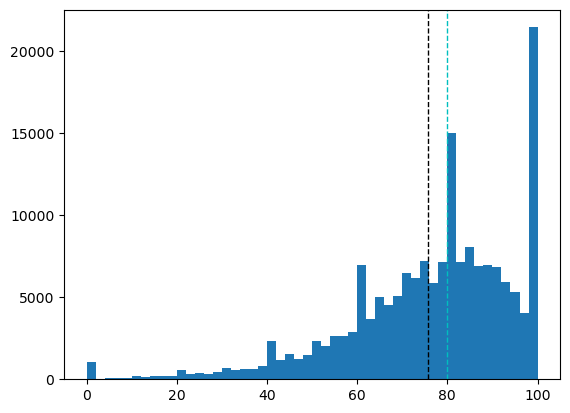

608


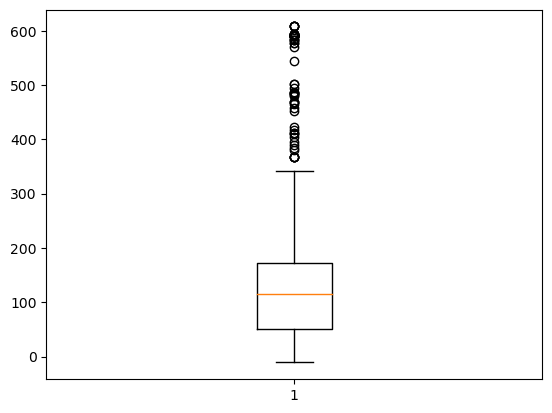

In [95]:
# understand the distibution of scores to get a sense of how students perform overall

score = results['score']
plt.hist(score, bins=50)
plt.axvline(score.mean(), color='k', linestyle='dashed', linewidth=1) # mean is black
plt.axvline(score.median(), color='c', linestyle='dashed', linewidth=1) # median is green
plt.show()

# understand date submitted to see when submissions take place and if there is anything unusual
date_sub = results['date_submitted']
print(date_sub.max())
plt.boxplot(date_sub)
plt.show()

It would be interesting to see how scores differ by assessment type later.

It appears that many assessments have been handed in beyond the course end date as the average course length is 255 days. The box plot is showing submission days over 350 as outliers. It is not possible to determine if these are due to errors in the data without speaking to the course administrators.

In [96]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [97]:
# correct ID data types

results['id_assessment'] = results['id_assessment'].astype(object)
results['id_student'] = results['id_student'].astype(object)

In [98]:
# missing values

results.isnull().sum() * 100 / len(results)

id_assessment     0.000000
id_student        0.000000
date_submitted    0.000000
is_banked         0.000000
score             0.099476
dtype: float64

Missing values are assumed ok as indicated in documentation that if a student doesn't submit an assessment, nothing is recorded. If this feature needs to be used in a calculation later, it may make sense to fill in the score with 0. This can be determined at a later time.

In [99]:
# duplicates

results[results.duplicated()]

,id_assessment,id_student,date_submitted,is_banked,score


### Student Info

This file contains demographic information about the students together with their results. File contains the following columns:
- code_module – an identification code for a module on which the student is registered.
- code_presentation - the identification code of the presentation during which the student is registered on the module.
- id_student – a unique identification number for the student.
- gender – the student’s gender.
- region – identifies the geographic region, where the student lived while taking the module-presentation.
- highest_education – highest student education level on entry to the module presentation.
- imd_band – specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation.
- age_band – band of the student’s age.
- num_of_prev_attempts – the number times the student has attempted this module.
- studied_credits – the total number of credits for the modules the student is currently studying.
- disability – indicates whether the student has declared a disability.
- final_result – student’s final result in the module-presentation.

In [101]:
stu_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


<Axes: title={'center': 'Student Gender'}, ylabel='count'>

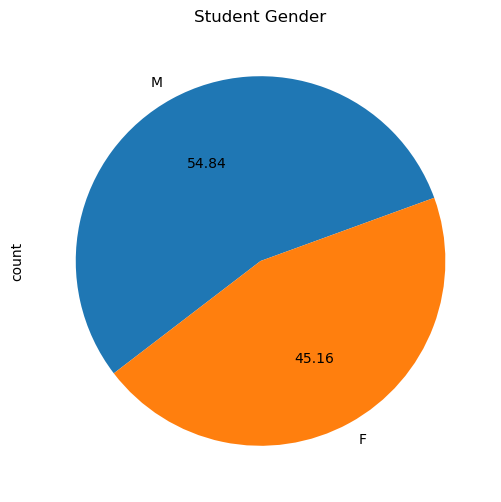

In [102]:
# understand gender

stu_info['gender'].value_counts().plot(kind='pie',autopct='%.2f',startangle=20, figsize =[10,6], title = "Student Gender")

<Axes: ylabel='count'>

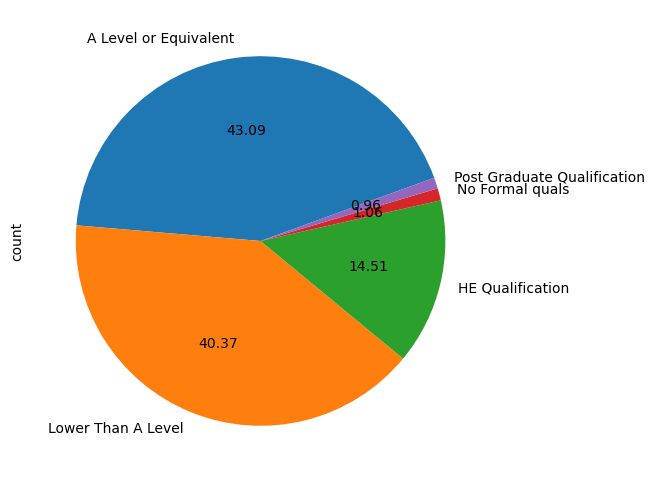

In [103]:
# understand highest education

stu_info['highest_education'].value_counts().plot(kind='pie', autopct='%.2f',startangle=20, figsize =[10,6])

In [104]:
# understand Index of Multiple Depravation band

stu_info['imd_band'].value_counts(normalize = True, sort = True) * 100

imd_band
20-30%     11.606632
30-40%     11.241344
10-20      11.168287
0-10%      10.517121
40-50%     10.342418
50-60%      9.923131
60-70%      9.227495
70-80%      9.144908
80-90%      8.773267
90-100%     8.055397
Name: proportion, dtype: float64

<Axes: ylabel='count'>

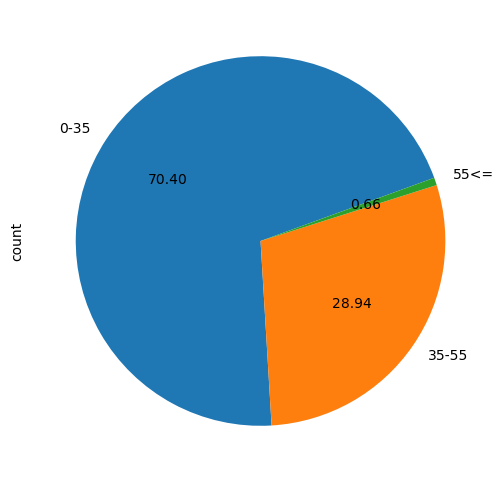

In [105]:
# understand age band

stu_info['age_band'].value_counts().plot(kind='pie', autopct='%.2f',startangle=20, figsize =[10,6])

<Axes: ylabel='count'>

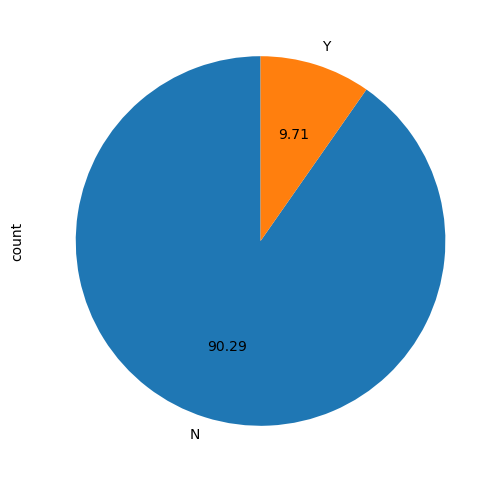

In [106]:
# understand disability

stu_info['disability'].value_counts().plot(kind='pie', autopct='%.2f',startangle=90, figsize =[10,6])

<Axes: ylabel='count'>

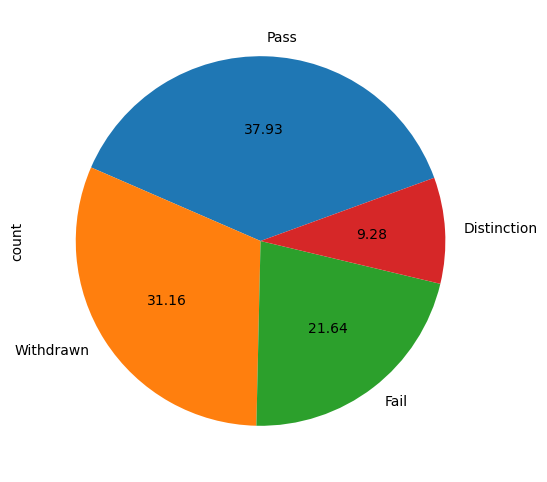

In [107]:
# understand final results

stu_info['final_result'].value_counts().plot(kind='pie', autopct='%.2f',startangle=20, figsize =[10,6])

final_result          Distinction  Fail   Pass  Withdrawn
num_of_prev_attempts                                     
0                            2857  5731  11148       8685
1                             143  1009    997       1150
2                              22   236    170        247
3                               1    57     31         53
4                               0    12     13         14
5                               0     6      2          5
6                               1     1      0          2


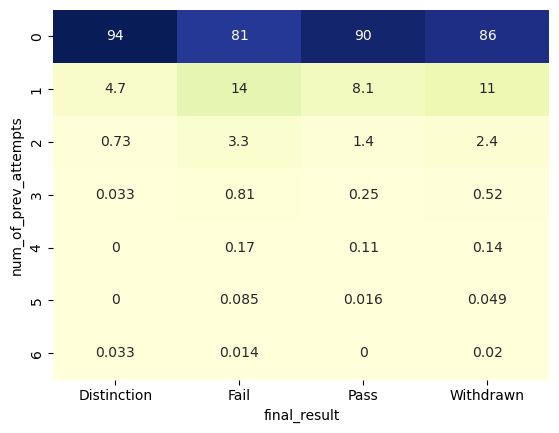

In [108]:
# of previous attempts with final result

pivot_table_result = pd.pivot_table(stu_info, 
                    values='id_student', 
                   index='num_of_prev_attempts',
                   columns='final_result', 
                   aggfunc='count',
                   fill_value=0)

print(pivot_table_result)

pivot_percentages = pivot_table_result.apply(lambda col: col / col.sum() * 100, axis=0)

import seaborn as sns
swarm_plot = sns.heatmap(pivot_percentages, cmap="YlGnBu", annot=True, cbar=False)
plt.show()

The withdrawn and fail rates appear to be very high. This seems like a good point for further investigation.

May want to investigate the relationship between attempts and fail rates.

<Axes: xlabel='region'>

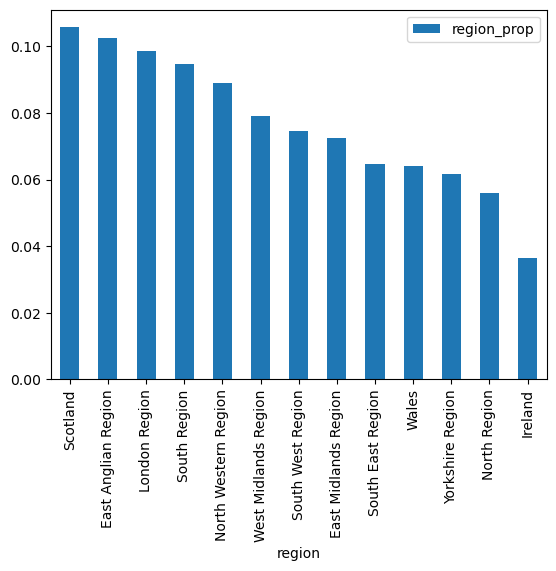

In [109]:
# understanding the regions

region_counts = stu_info['region'].value_counts(normalize = True, sort = True)
region_countsdf = region_counts.to_frame(name = 'region_prop')
region_countsdf['region'] = region_countsdf.index
region_countsdf.plot.bar(x = 'region',y = 'region_prop')

The regions appear to all be within the United Kingdom.

In [110]:
stu_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [111]:
# correct ID data types

stu_info['id_student'] = stu_info['id_student'].astype(object)

In [112]:
stu_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  object
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.0+ MB


In [113]:
# missing values

stu_info.isnull().sum() * 100 / len(results)

code_module             0.000000
code_presentation       0.000000
id_student              0.000000
gender                  0.000000
region                  0.000000
highest_education       0.000000
imd_band                0.638829
age_band                0.000000
num_of_prev_attempts    0.000000
studied_credits         0.000000
disability              0.000000
final_result            0.000000
dtype: float64

In [114]:
# duplicates

stu_info[stu_info.duplicated()]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result


### Interactions with Course Materials

The studentVle.csv file contains information about each student’s interactions with the materials in the VLE. This file contains the following columns:
- code_module – an identification code for a module.
- code_presentation - the identification code of the module presentation.
- id_student – a unique identification number for the student.
- id_site - an identification number for the VLE material.
- date – the date of student’s interaction with the material measured as the number of days since the start of the module-presentation.
- sum_click – the number of times a student interacts with the material in that day.

In [115]:
mater_inter.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [116]:
mater_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [117]:
# correct ID data types

mater_inter['id_student'] = mater_inter['id_student'].astype(object)
mater_inter['id_site'] = mater_inter['id_site'].astype(object)

In [118]:
# missing values

mater_inter.isnull().sum() * 100 / len(results)

code_module          0.0
code_presentation    0.0
id_student           0.0
id_site              0.0
date                 0.0
sum_click            0.0
dtype: float64

In [120]:
# duplicates

mater_inter[mater_inter.duplicated()]

,code_module,code_presentation,id_student,id_site,date,sum_click
2,AAA,2013J,28400,546652,-10,1
63,AAA,2013J,45462,546652,-10,1
180,AAA,2013J,77367,546652,-10,4
193,AAA,2013J,94961,546652,-10,2
442,AAA,2013J,248270,546652,-10,4
...,...,...,...,...,...,...
10655235,GGG,2014J,686194,897083,267,1
10655250,GGG,2014J,676071,896939,268,1
10655256,GGG,2014J,642905,896939,268,2
10655261,GGG,2014J,625530,896939,269,1


It could makes sense for there to be duplicates here if each record was recorded with a more specific date time initially (more than one interaction in a day). It may make sense to group the sum_click column, to be determined.

### Virual Learning Environment Materials

The csv file contains information about the available materials in the VLE. Typically these are html pages, pdf files, etc. Students have access to these materials online and their interactions with the materials are recorded. The -vle.csv file contains the following columns:
- id_site – an identification number of the material.
- code_module – an identification code for module.
- code_presentation - the identification code of presentation.
- activity_type – the role associated with the module material.
- week_from – the week from which the material is planned to be used.
- week_to – week until which the material is planned to be used.

In [122]:
mater.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [123]:
mater.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [124]:
# understand types of activities

mater['activity_type'].value_counts(normalize = True, sort = True)

activity_type
resource          0.417976
subpage           0.165776
oucontent         0.156505
url               0.139221
forumng           0.030484
quiz              0.019956
page              0.016028
oucollaborate     0.012885
questionnaire     0.009585
ouwiki            0.007700
dataplus          0.004400
externalquiz      0.004085
homepage          0.003457
ouelluminate      0.003300
glossary          0.003300
dualpane          0.003143
repeatactivity    0.000786
htmlactivity      0.000629
sharedsubpage     0.000471
folder            0.000314
Name: proportion, dtype: float64

In [125]:
# correct ID data types

mater['id_site'] = mater['id_site'].astype(object)

In [126]:
# missing values

mater.isnull().sum() * 100 / len(results)

id_site              0.000000
code_module          0.000000
code_presentation    0.000000
activity_type        0.000000
week_from            3.014743
week_to              3.014743
dtype: float64

It is not possible to determine why week_from and week_to are not filled in without speaking with a course administrator. Perhaps some materials were not planned to be used.

In [127]:
# duplicates

mater[mater.duplicated()]

,id_site,code_module,code_presentation,activity_type,week_from,week_to


### Student Registration

This file contains information about the time when the student registered for the module presentation. For students who unregistered the date of unregistration is also recorded. File contains five columns:
- code_module – an identification code for a module.
- code_presentation - the identification code of the presentation.
- id_student – a unique identification number for the student.
- date_registration – the date of student’s registration on the module presentation, this is the number of days measured relative to the start of the module-presentation (e.g. the negative value -30 means that the student registered to module presentation 30 days before it started).
- date_unregistration – date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation. Students, who completed the course have this field empty. Students who unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file.

In [130]:
stu_reg.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [131]:
stu_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [132]:
# correct ID data types

stu_reg['id_student'] = stu_reg['id_student'].astype(object)

In [133]:
# missing values

stu_reg.isnull().sum() * 100 / len(results)

code_module             0.000000
code_presentation       0.000000
id_student              0.000000
date_registration       0.025875
date_unregistration    12.949653
dtype: float64

For investigation after joining in mySQL ensure there is continuity between those students who registered and their course participation. Those who withdrew should have that represented in the results dataset.

In [134]:
# duplicates

stu_reg[stu_reg.duplicated()]

,code_module,code_presentation,id_student,date_registration,date_unregistration


## Send Final Data to MySql Database

In [75]:

pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [136]:
import mysql.connector
from sqlalchemy import create_engine

# your database connection details
DB_NAME = 'OULAD'
USERNAME = 'root'
PASSWORD = 'kekoukekou88!'
HOST = '127.0.0.1'

# connect to MySQL using mysql.connector
cnx = mysql.connector.connect(user=USERNAME, password=PASSWORD, host=HOST, database=DB_NAME)

# create a SQLAlchemy engine
engine = create_engine(f"mysql+mysqlconnector://{USERNAME}:{PASSWORD}@{HOST}/{DB_NAME}")

# insert data into existing mysql tables
try:
    assess_final.to_sql('assessments', con=engine, if_exists='replace', index=False)
    print("Data inserted into 'assessments' table.")
except mysql.connector.Error as err:
    print("Error inserting data into 'assessments' table: {}".format(err))

try:
    cour.to_sql('courses', con=engine, if_exists='replace', index=False)
    print("Data inserted into 'courses' table.")
except mysql.connector.Error as err:
    print("Error inserting data into 'courses' table: {}".format(err))

try:
    results.to_sql('assessment_results', con=engine, if_exists='replace', index=False)
    print("Data inserted into 'assessment_results' table.")
except mysql.connector.Error as err:
    print("Error inserting data into 'courses' table: {}".format(err))

try:
    stu_info.to_sql('student_info', con=engine, if_exists='replace', index=False)
    print("Data inserted into 'student_info' table.")
except mysql.connector.Error as err:
    print("Error inserting data into 'courses' table: {}".format(err))

try:
    mater_inter.to_sql('interactions', con=engine, if_exists='replace', index=False, chunksize = 2000)
    print("Data inserted into 'interactions' table.")
except mysql.connector.Error as err:
    print("Error inserting data into 'courses' table: {}".format(err))

try:
    stu_reg.to_sql('student_registration', con=engine, if_exists='replace', index=False, chunksize = 2000)
    print("Data inserted into 'student_registration' table.")
except mysql.connector.Error as err:
    print("Error inserting data into 'courses' table: {}".format(err))

try:
    mater.to_sql('vle_materials', con=engine, if_exists='replace', index=False, chunksize = 2000)
    print("Data inserted into 'vle_materials' table.")
except mysql.connector.Error as err:
    print("Error inserting data into 'courses' table: {}".format(err))

# close the SQLAlchemy engine
engine.dispose()

# commit the changes and close the connections
cnx.commit()
cnx.close()

Data inserted into 'assessments' table.
Data inserted into 'courses' table.
Data inserted into 'assessment_results' table.
Data inserted into 'student_info' table.
Data inserted into 'interactions' table.
Data inserted into 'student_registration' table.
Data inserted into 'vle_materials' table.
